In [1]:
import os
from os import walk
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#------------------- START FUNCTIONS -----------------------------------------#
def read_data(file):  
    #import the datasets and labels
    d = pd.read_csv(file, delimiter=",", engine='python',header=None, dtype={ 'bookingID': np.int64, 'Accuracy': np.int32, 'Bearing': np.int32, 'acceleration_x': np.float64, 'acceleration_y': np.float64, 'acceleration_z': np.float64, 'gyro_x': np.float64, 'gyro_y': np.float64, 'gyro_z': np.float64, 'second': np.int32, 'Speed': np.int32  })
    print(file)
    return d

#------------------- END FUNCTIONS -----------------------------------------#


#read in the data
#fetch all files inside the features dir
files = os.listdir(os.getcwd()+'/features')

#create and append individual csv files to one single data frame
dataset = pd.DataFrame()
for file in files:
    file = os.getcwd()+'/features/'+file
    if file.endswith('.csv'):
        dataset = dataset.append(read_data(file))

/home/biinths/features/part-00008-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00009-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00004-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00006-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00005-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00007-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00002-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00001-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
/home/biinths/features/part-00003-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv


In [2]:
labels = pd.read_csv('label.csv', delimiter=",", header='infer')

In [3]:
labels = labels[labels.bookingID != 0]

In [4]:
#rename columsn in the dataframe
pd.options.display.float_format = '{:.2f}'.format

dataset.columns = ['bookingID', 'Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed']
columns = dataset.columns

labels = pd.read_csv('label.csv', delimiter=",", header='infer')
dataset[columns] = dataset[columns].apply(pd.to_numeric, errors='coerce')

#drop rows with BookingId values as 0
dataset = dataset[dataset.bookingID != 0]
labels = labels[labels.bookingID != 0]

#merge the two datasets with the right labels - Use keys from right frame only
merged = pd.merge(dataset, labels, left_on=['bookingID'], right_on=['bookingID'], how='left')

In [5]:
labels.drop_duplicates(subset ="bookingID", keep = False, inplace = True) 
orig_data = labels

In [6]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

columns = dataset.columns
dataset[columns] = dataset[columns].apply(pd.to_numeric, errors='coerce')

#drop rows with BookingId values as 0
dataset = dataset[dataset.bookingID != 0]
labels = labels[labels.bookingID != 0]


merged = remove_outlier(merged, 'second')
merged = merged.sort_values(['bookingID','second'],ascending=True)

In [7]:
#Mean: the average value of the magnitude samples over a time window
mean_acc_gyro = merged.groupby('bookingID', as_index=False)\
        ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y', 'gyro_z'].rolling(4).mean().reset_index()



In [8]:
mean_acc_gyro.set_index('level_1', drop=True, inplace=True)

In [9]:
merged.index[0] == mean_acc_gyro.index[0]

True

In [10]:
#STORE AND EXTRACT MEAN OF EVERY WINDOW -
merged['MEAN_ACC_X'] = mean_acc_gyro.acceleration_x[3::4]
merged['MEAN_ACC_Y'] = mean_acc_gyro.acceleration_y[3::4]
merged['MEAN_ACC_Z'] = mean_acc_gyro.acceleration_z[3::4]
merged['MEAN_GYRO_X'] = mean_acc_gyro.gyro_x[3::4]
merged['MEAN_GYRO_Y'] = mean_acc_gyro.gyro_y[3::4]
merged['MEAN_GYRO_Z'] = mean_acc_gyro.gyro_z[3::4]

In [11]:
#Calculate Z-Crossing for accelerometer and gyroscope readings (how many times each point crosses the mean)
merged['CROSSOVER_ACC_X'] = (merged['acceleration_x'] > merged['MEAN_ACC_X'].bfill()).astype(int)
merged['CROSSOVER_ACC_Y'] = (merged['acceleration_y'] > merged['MEAN_ACC_Y'].bfill()).astype(int)
merged['CROSSOVER_ACC_Z'] = (merged['acceleration_z'] > merged['MEAN_ACC_Z'].bfill()).astype(int)

#Calculate Z-Crossing for accelerometer and gyroscope readings (how many times each point crosses the mean)
merged['CROSSOVER_GYRO_X'] = (merged['gyro_x'] > merged['MEAN_GYRO_X'].bfill()).astype(int)
merged['CROSSOVER_GYRO_Y'] = (merged['gyro_y'] > merged['MEAN_GYRO_Y'].bfill()).astype(int)
merged['CROSSOVER_GYRO_Z'] = (merged['gyro_z'] > merged['MEAN_GYRO_Z'].bfill()).astype(int)

In [12]:
#Variance: the average of the squared differences of the sample values from the mean value over a time window.
variance = merged.groupby('bookingID', as_index=False)\
        ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y', 'gyro_z'].rolling(4).var().reset_index()



In [13]:
variance.set_index('level_1', drop=True, inplace=True)

In [14]:
merged.index[0] == variance.index[0]

True

In [15]:
#STORE AND EXTRACT VA OF EVERY WINDOW -
merged['VAR_ACC_X'] = variance.acceleration_x[3::4]
merged['VAR_ACC_Y'] = variance.acceleration_y[3::4]
merged['VAR_ACC_Z'] = variance.acceleration_z[3::4]
merged['VAR_GYRO_X'] = variance.gyro_x[3::4]
merged['VAR_GYRO_Y'] = variance.gyro_y[3::4]
merged['VAR_GYRO_Z'] = variance.gyro_z[3::4]

In [16]:
merged.groupby('label').VAR_ACC_Y.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0.00,2782356.00,0.48,1.99,0.00,0.03,0.16,0.48,912.06
1.00,1179070.00,0.98,7.91,0.00,0.03,0.17,0.53,1740.19


In [17]:
merged['PITCH'] = np.arctan2(-merged.acceleration_x, np.sqrt(merged.acceleration_y * merged.acceleration_y + merged.acceleration_z * merged.acceleration_z)) * 57.3
merged['ROLL'] = np.arctan2(merged.acceleration_y, merged.acceleration_z) * 57.3


In [18]:
#GET MEAN OF ROLL AND PITCH FOR WINDOW
mean_pitch_roll = merged.groupby('bookingID', as_index=False)\
        ['ROLL','PITCH'].rolling(4).mean().reset_index()




In [19]:
mean_pitch_roll.set_index('level_1', drop=True, inplace=True)

In [20]:
merged.index[0] == mean_pitch_roll.index[0]

True

In [21]:
# MEAN AND ROLL EXTRACT FOR EACH WINDOW
merged['MEAN_ROLL'] = mean_pitch_roll.ROLL[3::4]
merged['MEAN_PITCH'] = mean_pitch_roll.PITCH[3::4]

In [22]:
#CHECK IF THE ACCELERATION POINTs AND GYROSCOPE CROSSES THE MEAN OF WINDOW : IF SO ASSIGN 1
merged['CROSSOVER_PITCH'] = (merged['ROLL'] > merged['MEAN_ROLL'].bfill()).astype(int)
merged['CROSSOVER_ROLL'] = (merged['PITCH'] > merged['MEAN_PITCH'].bfill()).astype(int)

In [23]:
# ECULIDEAN MAGNITUDE
merged['EUCLIDEAN_ACC'] = np.sqrt(np.square(merged['acceleration_x']) + \
                                  np.square(merged['acceleration_y']) + \
                                  np.square(merged['acceleration_z']))

In [24]:
#Variance: the average of the squared differences of the sample values from the mean value over a time window.
mean_ed_acc = merged.groupby('bookingID', as_index=False).EUCLIDEAN_ACC.rolling(4).mean().reset_index()

mean_ed_acc.set_index('level_1', drop=True, inplace=True)

In [27]:
merged['MEAN_ED_ACC'] = mean_ed_acc.EUCLIDEAN_ACC[3::4]
merged['CROSSOVER_ED_ACC'] = (merged['EUCLIDEAN_ACC'] > merged['MEAN_ED_ACC'].bfill()).astype(int)


In [28]:
#calculate bearing difference
bdiff = merged.groupby('bookingID', as_index=True)['Bearing'].diff()
merged['bearing_difference'] = bdiff

In [29]:
# intervals between data points
intervals =  merged.groupby('bookingID', as_index=True)['second'].diff()
merged['intervals'] = intervals

In [30]:
# speed diffrence between points
speed_diff =  merged.groupby('bookingID', as_index=True)['Speed'].diff()
merged['speed_diff'] = speed_diff

In [31]:
# calculate acceleration and bearing rates
merged['car_acceleration'] = abs(merged.speed_diff / merged.intervals)
merged['bearing_rate'] = abs(merged.bearing_difference / merged.intervals)

In [32]:
# distance covered at every point
merged['distance_covered'] = abs(merged.speed_diff * merged.intervals)

In [53]:
mergeda = merged
mergedb = merged
mergedc = merged

In [52]:
merged = mergeda

In [35]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


In [54]:
aggregates = merged.groupby('bookingID').agg({'distance_covered':['max'],
                            'bearing_rate':['max', 'var' ,'sum'],
                            'car_acceleration':['max'],
                            'bearing_rate':['max'],
                            'intervals':['sum'],
                            'CROSSOVER_ROLL':['sum'],
                            'CROSSOVER_PITCH':['sum'],
                            'MEAN_PITCH':['max','std'],
                            'MEAN_ROLL':['max','std'],
                            'VAR_GYRO_Z':['sum','mean','std'],
                            'VAR_GYRO_Y':['sum','mean','std'],
                            'VAR_GYRO_X':['sum','mean','std'],
                            'CROSSOVER_ED_ACC':['sum','mean'],
                            'EUCLIDEAN_ACC':['sum', 'mean','var'],
                            'CROSSOVER_GYRO_Z':['sum'],
                            'CROSSOVER_GYRO_Y':['sum'],
                            'CROSSOVER_GYRO_X':['sum'],
                            'CROSSOVER_ACC_Z':['sum'],
                            'CROSSOVER_ACC_Y':['sum'],
                            'CROSSOVER_ACC_X':['sum']})

In [55]:
aggregates.columns = aggregates.columns.map('|'.join).str.strip('|')

In [56]:
#merge aggregate vectors to the orginal label data
merged = pd.merge(orig_data, aggregates, left_on=['bookingID'], right_on=['bookingID'], how='left')


#rearrange columsn so that label goes to the end of frame
labels = merged['label']
merged = merged.drop(columns='label')
merged['label'] = labels

merged =  merged.dropna(how='any')   


In [57]:
merged = merged.drop(columns = ['bookingID'])

In [58]:
d = len(merged.columns) -1

In [59]:
"""BUILD THE MODEL"""
#split the dataset
X = merged.iloc[:,:d]
y = merged.iloc[:,d]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=232323, stratify =y)

In [70]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state = 3456)

grid_search_params = {'n_estimators': [160],
                    'max_features': [0.1,0.2,0.3,0.4,0.5,0.7],
                    'max_depth': [5,10,25],
                    'min_samples_split': [0.01,0.02,0.8]}


grid_search = GridSearchCV(estimator = model, param_grid = grid_search_params, cv = 10, n_jobs = 16, verbose = 3, scoring='roc_auc')

grid_search.fit(X_train,y_train)



Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:   33.2s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:  1.6min
[Parallel(n_jobs=16)]: Done 480 tasks      | elapsed:  4.3min
[Parallel(n_jobs=16)]: Done 540 out of 540 | elapsed:  5.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=3456, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=16,
       param_grid={'n_estimators': [160], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7], 'max_depth': [5, 10, 25], 'min_samples_split': [0.01, 0.02, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [71]:

model = grid_search.best_estimator_

In [72]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 0.5,
 'min_samples_split': 0.01,
 'n_estimators': 160}

In [63]:
"""# fit model no training data
model = RandomForestClassifier(n_estimators=160 , max_depth = 10, min_samples_split=0.01, max_features= 0.8, n_jobs = 17, verbose =0)
model.fit(X_train, y_train)
"""

'# fit model no training data\nmodel = RandomForestClassifier(n_estimators=160 , max_depth = 10, min_samples_split=0.01, max_features= 0.8, n_jobs = 17, verbose =0)\nmodel.fit(X_train, y_train)\n'

In [77]:
cv_score = cross_val_score(model, X_test, y_test, cv=5, scoring='roc_auc')
cv_score
sum(cv_score) / len(cv_score)

0.7160693258324755

In [76]:
cv_score

array([0.73419039, 0.73393327, 0.71451485, 0.7153719 , 0.68250801,
       0.69288002, 0.72521557, 0.71140675, 0.75383099, 0.7330157 ])

In [78]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(cm)

[[4810  139]
 [1335  309]]


In [79]:
feature_importances = pd.DataFrame(model.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance',                                                                 ascending=False)
print(feature_importances)
# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

                       importance
intervals|sum                0.32
EUCLIDEAN_ACC|var            0.12
distance_covered|max         0.05
MEAN_PITCH|std               0.04
MEAN_ROLL|std                0.04
EUCLIDEAN_ACC|sum            0.03
VAR_GYRO_X|sum               0.03
VAR_GYRO_X|mean              0.02
bearing_rate|max             0.02
CROSSOVER_ACC_Z|sum          0.02
MEAN_PITCH|max               0.02
CROSSOVER_ACC_Y|sum          0.02
MEAN_ROLL|max                0.02
car_acceleration|max         0.02
CROSSOVER_ROLL|sum           0.02
CROSSOVER_GYRO_Y|sum         0.02
VAR_GYRO_Z|sum               0.02
EUCLIDEAN_ACC|mean           0.02
CROSSOVER_ACC_X|sum          0.02
VAR_GYRO_Y|std               0.02
VAR_GYRO_Z|mean              0.02
CROSSOVER_GYRO_Z|sum         0.01
CROSSOVER_GYRO_X|sum         0.01
CROSSOVER_PITCH|sum          0.01
VAR_GYRO_X|std               0.01
CROSSOVER_ED_ACC|mean        0.01
VAR_GYRO_Z|std               0.01
CROSSOVER_ED_ACC|sum         0.01
VAR_GYRO_Y|mea

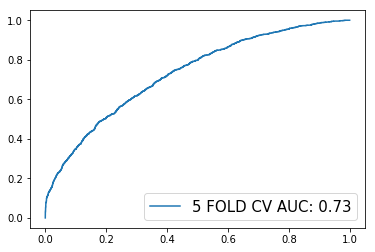

In [80]:
pyplot.plot(fpr,tpr,label="5 FOLD CV AUC: {:.2f}".format( auc ))
pyplot.legend(loc=4, prop={'size': 15})
pyplot.show()

In [81]:
filename = '____73.0 CV AUC_FINAL_V4.0.sav'
joblib.dump(model, filename, compress=3)

['____73.0 CV AUC_FINAL_V4.0.sav']